In [1]:
%matplotlib inline
import sys
sys.path.append("/home/diego/Dropbox/hold_noise/iclamp-glm/")

import matplotlib.pyplot as plt
import numpy as np

from icglm.vglm import VGLM
from icglm.iclamp import IClamp
from icglm.kernels import KernelRect

%load_ext autoreload
%autoreload 2

In [21]:
ic = IClamp.load_from_abf(path='./18o03049.abf')
ic = ic.sweeps([0])
ic = ic.subtract_Ih(th=1000.1).restrict(t0=1000.1, tf=11000.1)
ic.set_mask_spikes(thr=0, t_before_spike_peak=0.8)
mask_subthreshold = ic.get_mask_away_from_spikes(2, 20, t0=1500)

dict_keys(['data', 'mask_subthreshold'])
dict_keys(['X_spikes', 'X', 'X_sub', 'data_sub', 'Y_spikes', 'Y'])
Starting gradient ascent... 

 Iteration 86 of 120 | Elapsed time: 45.36 seconds | log_prior=nan | log_posterior=-985.29
 
 Iteration 86 of 120 | Converged | Elapsed time: 0.756 minutes | Log posterior is monotonic 

u0 -60.680517584974595
vt -41.29162136452691
dv 1.2278297186250575


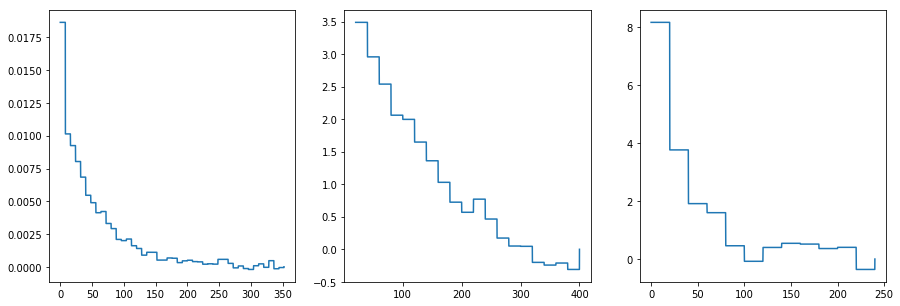

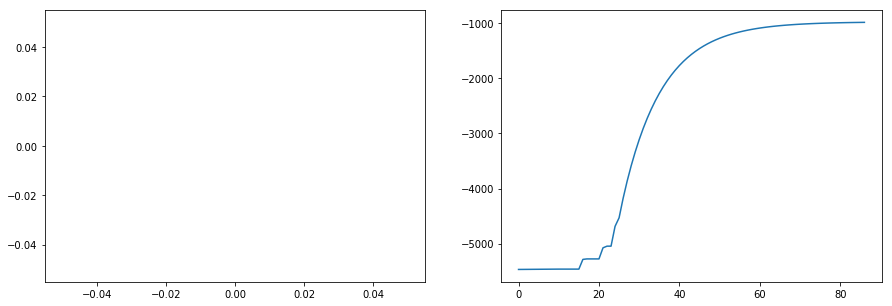

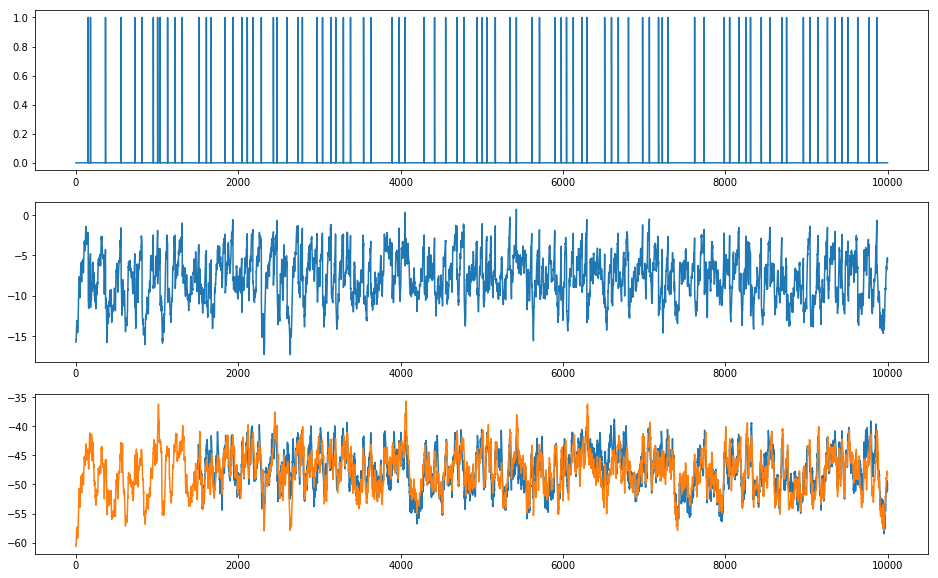

In [33]:
tbins_kappa = np.arange(0, 360, 8)
coefs_kappa0 = 1e-2 * np.exp(-tbins_kappa[:-1] / 50)
tbins_eta = np.arange(20, 420, 20)
coefs_eta0 = 6 * np.exp(-tbins_eta[:-1] / 50)
tbins_gamma = np.arange(0, 260, 20)
coefs_gamma0 = 6 * np.exp(-tbins_gamma[:-1] / 50)

theta0 = np.concatenate((np.array([-60]), coefs_kappa0, coefs_eta0, [-30], coefs_gamma0, [0.9]))
newton_kwargs = dict(max_iterations=120, stop_cond=1e-3, learning_rate=5e-2, initial_learning_rate=5e-8, warm_up_iterations=10)

# en 8e-3 no le pesa mucho el voltage
# en 1e-2 parece que ya fitea voltage con toda. brusca transicion
vglm = VGLM(kappa=KernelRect(tbins_kappa), eta=KernelRect(tbins_eta), gamma=KernelRect(tbins_gamma), lam=9e-3)
optimizer = vglm.fit(ic.t, ic.stim, ic.mask_spikes, data=ic.data, mask_subthreshold=mask_subthreshold, theta0=theta0, newton_kwargs=newton_kwargs,verbose=True)
print('u0', vglm.vr)
print('vt', vglm.vt)
print('dv', vglm.dv)

v, r, mask_spk = vglm.sample(ic.t, ic.stim)

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15, 5), ncols=3)
vglm.kappa.plot(ax=ax1)
vglm.eta.plot(ax=ax2)
vglm.gamma.plot(ax=ax3)

fig, (ax1, ax2) = plt.subplots(figsize=(15, 5), ncols=2)
ax1.plot(optimizer.log_prior_iterations)
ax2.plot(optimizer.log_posterior_iterations)

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(16, 10), nrows=3)
ax1.plot(ic.t, mask_spk)
ax2.plot(ic.t, np.log(r))
ax3.plot(ic.t[mask_subthreshold[:, 0]], ic.data[mask_subthreshold])
ax3.plot(ic.t, v)